In [1]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt
import My_Functions as fnc

## Calibration
The Code below reads the images of the chessboard from the calibration file and estimates the calibration parameters including the calibtation matrix and the distorsion coefficients.

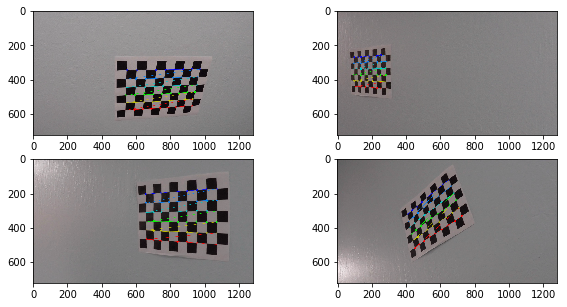

In [2]:
# Camera Calibration
calib_file = 'camera_cal/'
calib_img = os.listdir(calib_file)

nx = 9
ny = 6

image_points = []
object_points = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fig, axs = plt.subplots(2, 2, figsize = (10, 5))
axs = axs.ravel()
counter = 0
for image_name in calib_img:
    
    image = cv2.imread(calib_file + image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # Ploting the 4 of the chessboard images with detected corners
    if ret == True and counter<4:
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        axs[counter].imshow(image)
        counter+=1
        
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)
    
fig.savefig("output_images/calibration.jpg", bbox_inches = 'tight')
        
ret, mtx, dist, rvecs, tvects = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

## Image correction
The next code cell undistorts an example image from the chessborad.

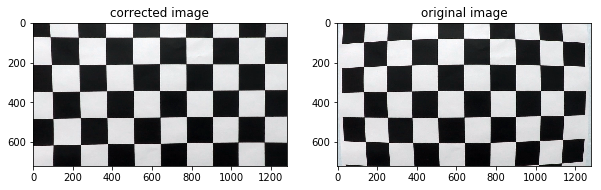

In [3]:
# undistort two example images:
img = cv2.imread(calib_file + calib_img[0])
dst = cv2.undistort(img, mtx, dist,None, mtx)

fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(dst)
axs[0].set_title('corrected image')
axs[1].imshow(img)
axs[1].set_title('original image')

fig.savefig('output_images/corrected_test_image.jpg', bbox_inches = 'tight')

# Line Detection Pipe Line

After obtaining the camera calibration parameters the lane detection pipline will be implemented step by step. First each step of the algorithm will be explaned in the next following code cells, and at the end all these steps will be abstracted into a function make the processing easier.

## 1. Correcting the original images from the camera

The first step is to correct the distorsions in the images obtained from the camera. The camera calibration parameters were computed in the previous section, and the image correction can be performed as follows.

In [4]:
# Select one of the images from the test images folder to start implementing advanced lane finding method
test_images_file = "test_images/"
test_images = os.listdir(test_images_file)

image_name = test_images_file + test_images[0]
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
# Undistord the selected test image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)
RGB_undist = cv2.cvtColor(undist_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("output_images/corrected.jpg", RGB_undist)

True

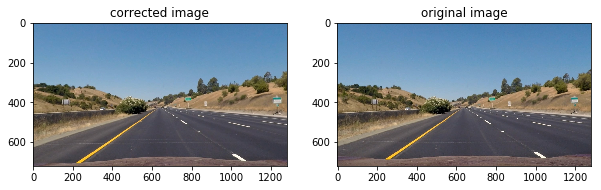

In [6]:
fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(undist_image)
axs[0].set_title('corrected image')
axs[1].imshow(image)
axs[1].set_title('original image')

fig.savefig("output_images/road_image_corrected.jpg", bbox_inches = 'tight')

## 2.Color Threshold

After applying the correction for distorsion a color threshold is applied to the images to keep the lane lines while discarding the most of the other pixels in the image that are not associated with lane lines.

The original images are in RGB color space. However, the HLS color space can do a better job especially when the road texture is varying or shadows are perestnt in the scene. Thefore the images will be transformed to the HLS color space, and the threshold will be applied on the S channel.

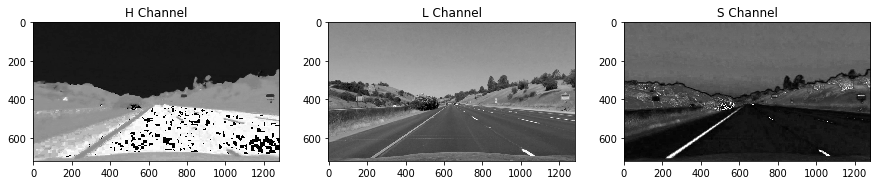

In [7]:
# Color Threshold on HLS(Hue, Lightness, saturation) images 
HLS_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2HLS)

H_channel = HLS_img[:,:,0]
L_channel = HLS_img[:,:,1]
S_channel = HLS_img[:,:,2]

fig, axs = plt.subplots(1,3, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(H_channel, cmap = 'gray')
axs[0].set_title('H Channel')

axs[1].imshow(L_channel, cmap = 'gray')
axs[1].set_title("L Channel")

axs[2].imshow(S_channel, cmap = 'gray')
axs[2].set_title('S Channel')

fig.savefig("output_images/HLS.jpg", bbox_inches = 'tight')

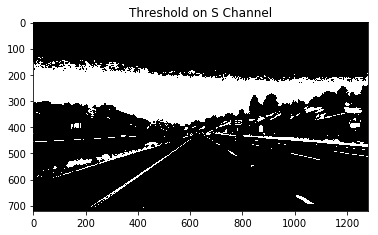

In [8]:
# Threshold the S channel. The threshold values should be tuned carefully.
thresh = (150, 255)
S_binary = np.zeros_like(S_channel)
S_binary[(L_channel>thresh[0]) & (L_channel<=thresh[1])] = 1

fig = plt.figure()
plt.imshow(S_binary, cmap = 'gray')
plt.title('Threshold on S Channel')

fig.savefig("output_images/threshold_S.jpg", bbox_inches = 'tight')

## 3. Gradient Threshold

Color space threshold can be combined with gradient threshold to obtain a more robust pipeline. First the the RGB images will be conveted to gray scale, and then the gradient will be computed in $x$ and $y$ direction.

The amplitude of the gradient and the direction of the gradient vectors can be also obtained.

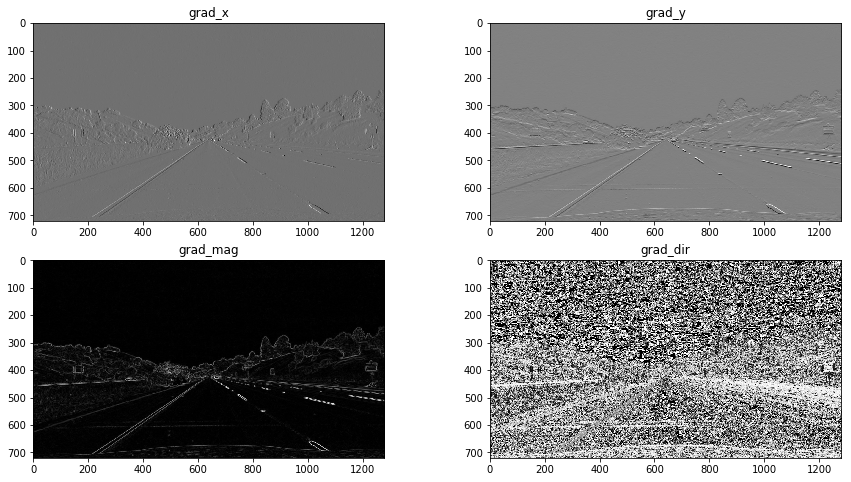

In [9]:
# Gradiend
gray_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_dir = np.arctan2(np.abs(grad_y),np.abs(grad_x))

fig, axs = plt.subplots(2,2, figsize = (15,8))
axs = axs.ravel()

axs[0].imshow(grad_x, cmap = 'gray')
axs[0]. set_title("grad_x")

axs[1].imshow(grad_y, cmap = 'gray')
axs[1]. set_title("grad_y")


axs[2].imshow(grad_mag, cmap = 'gray')
axs[2]. set_title("grad_mag")

axs[3].imshow(grad_dir, cmap = 'gray')
axs[3]. set_title("grad_dir")

fig.savefig("output_images/gradient.jpg", bbox_inches = 'tight')

In the My_Functions.py file the gradient threshold function is implemented. This function takes the RGB image and the threshold bounds as its inputs and generates a binary image based on the thresholds. The code cell below shows how this functions works.

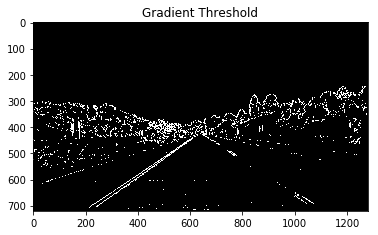

In [10]:
thresh_x = (30, 255)
thresh_y = (200, 255)
thresh_m = (25, 255)
thresh_d = (0.35, 1.57)

grad_thr = fnc.grad_thresh(undist_image, thresh_x, thresh_y, thresh_m, thresh_d)

fig = plt.figure()
plt.imshow(grad_thr, cmap = 'gray')
plt.title("Gradient Threshold")

fig.savefig('output_images/gradient_thr.jpg', bbox_inches = 'tight')

## 4. Combining the gradient threshold and color threshold
As mentioned earlier the thresholds should be combined inorder to obtain a better lane detection pipeline. The code cell below combines the two binary images from gradient threshold and color threshold.

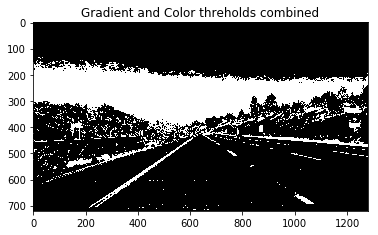

In [11]:
combined_thr = fnc.combine_thresholds(grad_thr, S_binary)

fig = plt.figure()
plt.imshow(combined_thr, cmap = 'gray')
plt.title('Gradient and Color threholds combined')

fig.savefig("output_images/combined_thr.jpg", bbox_inches = "tight")

## 5. Bird Eye view of the road

Normally the camera will be placed in front of the car. However, having a bird eye view from the top is much more helpful for detecting lane lines. The bird eye view can be obtained by applying a prespective transformation to the original images from the camera.

In order to find the desired prespective transformation four points on a trapazoid will be selected as the source points. These four points will form a rectangle in the bird eye view which will be considered as the destinations points. This opration is encapsulated in the function "warp" in the My_Functions.py file. This function get the undistorted image as its input and provides the bird eye view of the image along with the inverse transfomration matrix which is essential in the next stages of the pipeline.

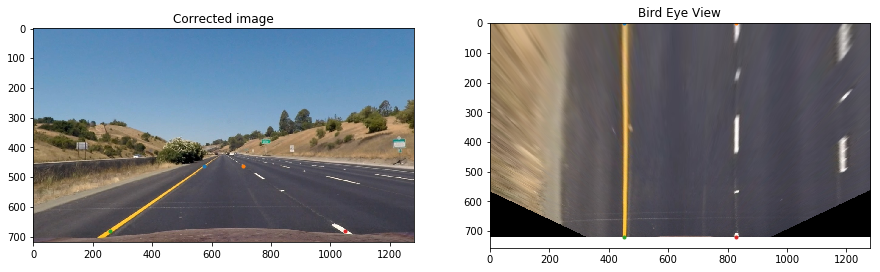

In [12]:
# Use perespective transform to obtain a birds eye view of the road
bird_eye, Minv = fnc.warp(undist_image)

fig, axs = plt.subplots (1, 2, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(undist_image)
axs[0].plot(575,464,'.')
axs[0].plot(707,464,'.')
axs[0].plot(258,682,'.')
axs[0].plot(1049,682,'.')
axs[0].set_title('Corrected image')

axs[1].imshow(bird_eye)
axs[1].plot(450, 0,'.')
axs[1].plot(830, 0,'.')
axs[1].plot(450, 720,'.')
axs[1].plot(830, 720,'.')
axs[1].set_title('Bird Eye View')

fig.savefig("output_images/Bird_Eye.jpg", bbox_inches = 'tight')

The bird eye view can be applied on the binary image as shown below. The whole process of obtaining the bird eye view of the binary from the original images are abstracted in the function "Generate_Binary_Warped" in My_Functions.py file.

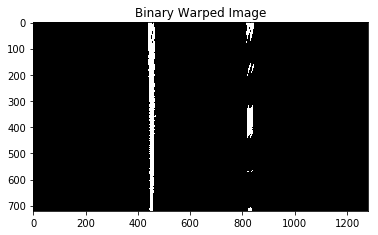

In [13]:
import My_Functions as fnc

binary_warped, _, _ = fnc.Generate_Binary_Warped(image, mtx, dist)

fig = plt.figure()
plt.imshow(binary_warped, cmap = 'gray')
plt.title("Binary Warped Image")
fig.savefig("output_images/binary_waped.jpg", bbox_inches = 'tight')

## 6. Fitting Polynomials to the Left and Right Lanes
Once the binary_warped image is formed the left and right lane should be distinguished first. This process has been expalained in the lane detection lessons throughly. There for I will be just pointing them out.

1- The histogram of the pixels for the lower half of the image is formed and the location of the left and right lane can be estimated based on the location of the peaks in the histogram.

2- The histogram can provide a rogh estimation of the location of the lanes as a starting point. For a better estimation I used the sliding window method from the lessons to obtain a better estimation of the pixels that are corresponding to the lane lines.

3- After detecting the pixels that are corresponding to the left and right lanes a second order polynomial is fit to the pixels.

These steps are implemented in the "Image_Lane_detection". This function gets the binary_warped image as the input and fit the second order polynomial to the lane lines.

In [15]:
left_fit, right_fit, leftx, lefty, rightx, righty, left_lane_inds,right_lane_inds = fnc.Image_Lane_detection(binary_warped)

In [16]:
def Plot_Lane(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty):
    # Generate x and y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print(out_img.shape)
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    fig = plt.figure()

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Lane Detection')

    fig.savefig("output_images/detected_lanes.jpg", bbox_inches = 'tight')
    
    return ploty, left_fitx, right_fitx

(720, 1280, 3)


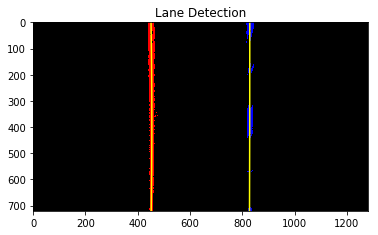

In [17]:
ploty, left_fitx, right_fitx = Plot_Lane(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty)

**Warping the detected lanes to the original images**

Once the left and right lanes are detected on the bird eye view the lines can be transformed back to the original image. As shown below.

**IMAGE_PROCESS function:**
I have encapsulated all of the previous steps and stages in a function name **IMAGE_PROCESS**. This function takes an RGB image as the input an gives back the annotated image where the lane lines are detected.

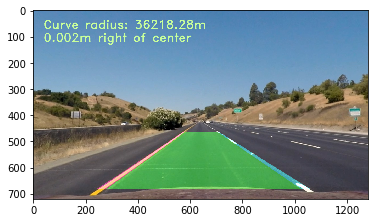

In [18]:
output, left_fit, right_fit, left_lane_inds, right_lane_inds = fnc.IMAGE_PROCESS(image, mtx, dist)
plt.imshow(output)

# Validation on the test images:
Before detecting the lane line on the video the pipeline has been tested on the test images to make sure that it is working properly. Moreover this test can be very hepful to fine tune some the user defined parameters of the pipeline such as the thresholds and the source and destination points for generating the bird eye veiew. The code cell below reads each one of the test images and shows the detected lane lines. As it is clear the pipeline has an accptable performance on the test images. Therefore, it is very likely that can do a good job is detecting the lane lines in the video.

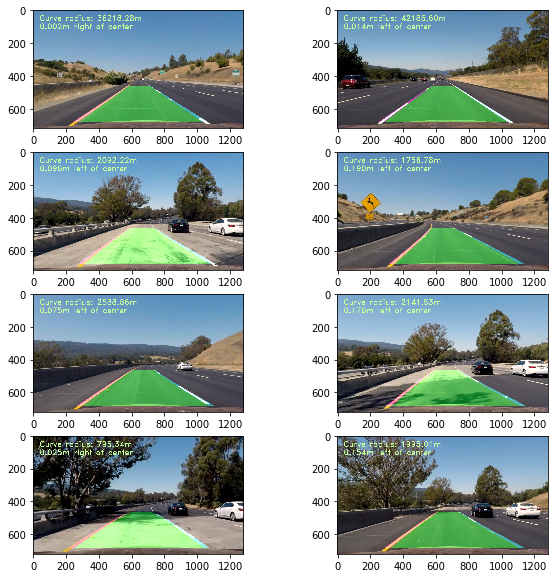

In [19]:
counter = 0
fig, axs = plt.subplots(4, 2 , figsize = (10, 10))

axs = axs.ravel()

for image_name in test_images:
    file_path = "test_images/"
    image_path = file_path + image_name
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    annotated_image, _, _, _, _ = fnc.IMAGE_PROCESS(image, mtx, dist)
    
    axs[counter].imshow(annotated_image)
    
    counter+=1
fig.savefig("output_images/Test_images_annotated.jpg", bbox_inches = 'tight')

In [20]:
# Process the video
video_name = 'project_video.mp4'
cap = cv2.VideoCapture(video_name)

fnc.VIDEO_PROCESS(cap, mtx, dist, 'My_Video.avi')